In [1]:
import numpy as np
import warnings
import seaborn as sns
import random
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, ListedColormap
from sklearn.preprocessing import normalize
from IPython.display import clear_output
import imageio
import os
import time

### Utiility functions
Hash a game state

Unhash a game state

Return display functions

Generate random color for color mapping

Epsilon schedule

In [2]:
def hashBoard(board):
    """
    Hash board as 1-D array string
    """
    return str(board.reshape(9))

def unhashBoard(state):
    """
    Convert 1-D array string to 3x3 float grid
    """
    return np.array([float(val) for val in state.replace("[", "").replace("]", "").replace(' ', '').split('.') if val]).reshape(3,3)

def displayGenerator(**kwargs):
    """
    Return visualization function defined by kwargs (passed to seaborn.heatmap)
    """
    def displayBoard(board):
        hm = sns.heatmap(board, **kwargs)
        return hm

    return displayBoard

def generateColor():
    """
    Generate random color for color map
    """
    color = hex(random.randint(0,255))
    return color

def epsilonSchedule(rate):
    def schedule(actor):
        return actor.epsilon - rate
    return schedule

# Game Model
This class handles management of the Tic Tac Toe game. It tracks (and generates) actors for the game, the current board, board color mapping, round information, turn information, and end-state management

In [3]:
class TicTacToe:
    def __init__(self, actors=[]):
        # Track actors for the game
        if not actors:
            actors = [Actor(1, "blue"), Actor(-1, "red")]
        self.actors = actors
        # Track current board state
        self.board = np.zeros(shape=(3,3))

        # Track actor values to ensure no improper vales
        self.values = [a.value for a in actors]
        # Map actor values to actors to reference later
        self.vmap = {a.value : a for a in actors}
        # Value assertions
        assert 0 not in self.values, "WARNING : 0 is not a valid actor value"
        assert len(self.values) == len(set(self.values)), "WARNING : The actors do not have strictly unique values"
        # Add 0 value for color mapping
        self.values = [0] + self.values
        
        # Track actor colors to ensure no improper colors
        self.colors = [a.color for a in actors]
        # Color assertions
        assert len(self.colors) == len(set(self.colors)), "WARNING : The actors do not have strictly unique colors"
        assert "white" not in self.colors, "WARNING : white is not a valid actor color"
        # Add white for color mapping
        self.colors = ["white"] + self.colors
        # Generate color map
        cmapping = {v:c for v,c in zip(self.values, self.colors)}
        self.cmap = ListedColormap([cmapping[v] for v in sorted(self.values)], N=len(self.colors))
        
        # Game-specific information
        self.played = []
        self.round = 1
        self.turn = 1
        self.ended = False

    def reset(self):
        """
        Reset board and game information to run the game again.
        Technically unecessary for single-games and simulations, but minimizes memory and operation time overhead
        """
        self.played = []
        self.round = 1
        self.turn = 1
        self.ended = False
        self.board = np.zeros(shape=(3,3))

    def verifyPlay(self, position):
        """
        Verify that the position trying to be played on is currently empty
        """
        return self.board[position[0],position[1]] == 0
        
    def play(self, actor, position):
        """
        Place the actor's value at the specified position
        
        Parameters:
            actor [Actor] : Actor that is making the move
            position [int,int] : 2-value pairing (0-indexed) coordinate of square to play on
        
        Raises:
            Warning : The actor has already played this round and must wait for the next round
            Warning : The position is not playable
            Warning : It is not the actor's turn
            Warning : Game is already over
        
        Behavior:
            Sets self.board[position] to actor.value
            Appends actor.value to round-specific player tracker
            Sets current turn to next player
            Sets self.ended to True if end state is reached
        
        Returns:
            True if the play was successfully made
            False if the play was not successfully made
        """
        # Make sure game isn't over
        if self.ended:
            warnings.warn(f"Game is over!")
            return False
        # Set to next round
        if len(self.played) == len(self.actors):
            self.played = []
            self.round += 1
        # Make sure actor has not played already
        if actor.value in self.played:
            warnings.warn(f"Actor {actor.value} already played this round")
            return False
        # Make sure position is playable
        if not self.verifyPlay(position):
            warnings.warn(f"Position {position} is not playable")
            return False
        # Make sure it is the actor's turn
        if actor.value != self.turn:
            warnings.warn(f"It is not {actor}'s turn!")
        # Set position
        self.board[position[0],position[1]] = actor.value
        # Track actor as played
        self.played.append(actor.value)
        # Shift turn
        self.turn *= -1
        # Check if someone won
        if self.winState():
            self.ended = True
        # Check if there are no more legal moves
        if len(np.argwhere(self.board==0)) == 0:
            self.ended = True
        return True
    
    def winner(self):
        """
        Return the winner of the game if one is present, else return 0
        """
        for i in range(3):
            # Check if any row is all same value
            if not (self.board[i,:] == 0).any() and (self.board[i, :] == self.board[i, 0]).all():
                return self.board[i,0]
            # Check if any column is all same value
            if not (self.board[:,i] == 0).any() and (self.board[:, i] == self.board[0, i]).all():
                return self.board[0,i]
        # Check if the main diagonal is all same value
        if not (np.diag(self.board) == 0).any() and (np.diag(self.board) == self.board[0,0]).all():
            return self.board[0,0]
        # Check if flipped diagonal is all same value
        if not np.diag(self.board[:,::-1] == 0).any() and (np.diag(self.board[:,::-1]) == self.board[0,2]).all():
            return self.board[0,2]
        
        return 0

    def winState(self):
        """
        If a winner is found, win-state is reached
        """
        return self.winner() != 0

    def reward(self):
        """
        Reward actors based on current win-state
        
        The winner of the game gets a reward of 1
        The loser gets a reward of -1
        If a tie is reached, both actors get a reward of 0.1
        
        We want the winner to prioritize boards that lead to the win-state
        We want the loser to avoid boards that lead to the win-state
        If neither actor won, neither actor lost, so this is only slightly preferable than losing.
        """
        result = self.winner()
        # No winner yet
        if result == 0:
            self.vmap[1].feed(0.1)
            self.vmap[-1].feed(0.1)
            return

        self.vmap[result].feed(1)
        self.vmap[-result].feed(-1)

    def copy(self):
        """
        Copy the board for consequent-state analysis
        """
        _copy = TicTacToe(self.actors)
        _copy.board = self.board.copy()
        return _copy

## Actor Models
Generic actor for the game and spcifically-tailored AI agents for the game

In [4]:
class Actor:
    def __init__(self, name, color, value):
        self.value = value
        self.color = color
        self.states = []
        self.victories = 0

        self.name = name
    
    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        return self.name
    
    def feed(self, reward):
        # Placeholder for AI actor
        return

In [5]:
class AIActor(Actor):
    def __init__(self, name, value, color, epsilon=0.3, gamma=0.9, lr=1e-4, epsilon_schedule=lambda a:a.epsilon):
        """
        Generate AI-tailored agent that tracks epsilon exploration rate, gamama reward decay, and learning rate
        """
        super(AIActor, self).__init__(name=name, value=value, color=color)
        self.epsilon = epsilon
        self.gamma = gamma
        self.lr = lr
        # State-value mapping Q-table
        self.state_values = {}
        self.epsilon_schedule = epsilon_schedule
    
    def chooseAction(self, board):
        """
        Chooses a posible action on the board
        
        Parameters:
            board [np.array] : Tic Tac Toe board to be played on
        
        Returns:
            Best possible move (or randomly explored move)
        """
        moves = np.argwhere(board==0) # possibilities
        max_val = -np.inf
        move = random.choice(moves)
        # Explore
        if np.random.uniform(0,1) > self.epsilon:
            # Find best possible move based on state-value mapping of consequent state
            # Copy the board
            _board = board.copy()
            # Check each move
            for m in moves:
                _board[m] = self.value
                # Check value of consequent state
                _hash = hashBoard(_board)
                _board[m] = 0
                value = 0 if _hash not in self.state_values.keys() else self.state_values[_hash]
                # Check if move is better than current best move
                if value > max_val:
                    move = m
                    max_val = value
        
        return move

    def feed(self, reward):
        """
        Give reward to actor
        
        The Q-table update isn't strictly the same as the algorithm reviewed in lecture.
        Since our Q-table only relies on consequent-state analysis, the specific actions
            that took us there are irrelevant (this is done to save memory and operation time overhead).
        This does change the behavior of the model, as it focuses more on the series of states that were passed through,
            as opposed to specific actions made.
        
        We iterate backwards through the states passed in the game.
        This gives the end-state the largest reward, and prior states get progressively lesser rewards.
        Rewards are propagated backwards through the game states.
        """
        if reward == 1:
            self.victories += 1
        # Go through each state from end-game to beginning
        for i,state in enumerate(reversed(self.states)):
            # If we haven't seen the state yet
            if state not in self.state_values.keys():
                self.state_values[state] = 0
            # Update state value
            board = unhashBoard(state)
            moves = np.argwhere(board==0)
            max_val = -np.inf
            # No consequent states for end-state board
            if i == 0:
                self.state_values[state] += self.lr * reward
            else:
                for move in moves:
                    board[move] = self.value
                    hashed = hashBoard(board)
                    board[move] = 0
                    score = 0 if hashed not in self.state_values.keys() else self.state_values[hashed]
                    if score > max_val:
                        max_val = score
                self.state_values[state] += self.lr * (reward + self.gamma * max_val - self.state_values[state])
            # Back-propagate reward
            reward = self.state_values[state]
        
        self.epsilon = self.epsilon_schedule(self)
    
    def addState(self, state):
        """
        Add state to this actor's history
        """
        self.states.append(hashBoard(state))
        
    def reset(self):
        """
        We only want to clear the actor's history, not its Q-table
        """
        self.states = []
    
    def visualizeStates(self, visualizer, n_states=-1, unhasher=unhashBoard):
        """
        Visualize the actor's Q-table. In particular, look at top n_states/2 and bottom n_state/2 Q-scores.
        
        Parameters:
            visualizer [function] : Visualization function that generates board visualizations
            n_states [int] : Number of states to visualize. Defaults to -1, which displays all boards
        """
        # Print top boards
        print(f"{self} : Best {n_states//2} states")
        if n_states == -1:
            n_states = len(self.state_values.keys()) * 2
        for state, score in sorted(self.state_values.items(), key=lambda x:x[1], reverse=True)[:n_states//2]:
            # Convert board hash back to original board
            _board = unhashBoard(state)
            visualizer(_board)
            plt.title(f"Board score : {score}")
            plt.show()
            plt.clf()
        # If n_states is -1, we have already dipslayed all boards
        if n_states == -1:
            return
        print(f"{self} : Worst {n_states//2} states")
        for state, score in sorted(self.state_values.items(), key=lambda x:x[1], reverse=False)[:n_states//2]:
            _board = unhashBoard(state)
            visualizer(_board)
            plt.title(f"Board score : {score}")
            plt.show()
            plt.clf()

## Simulation
Simulation used to train AI actors

In [6]:
class Simulation:
    def __init__(self, game, display=None, **kwargs):
        """
        Track game and display function
        """
        self.game = game
        self.display = display if display else displayGenerator(**kwargs)
    
    def play(self, iterations=1000, verbose=False, n_track=-1):
        """
        Play many games to train actors in self.game
        
        Parameters:
            iterations [int] : Number of games to run
            verbose [bool] : If True, displays boards after every move
            n_track [int] : Number of winning states to track [defaults to all]
        """
        # Track win states passed
        states = [None for _ in range(n_track)] if n_track != -1 else []
        # Track winners
        winners = [None for _ in range(n_track)] if n_track != -1 else []
        # Tracking position for states and winner
        track_position = 0
        # Who gets to play first (changes each game)
        first_player = -1
        # Run games
        for i in tqdm(range(iterations)):
            # Switch first player
            first_player *= -1
            self.game.turn = first_player
            # Run game
            while not self.game.ended:
                # Display the board
                if verbose:
                    time.sleep(1)
                    plt.clf()
                    self.display(self.game)
                    plt.show()
                # First actor
                a1 = self.game.vmap[first_player]
                a2 = self.game.vmap[-first_player]
                a1_move = a1.chooseAction(self.game.board)
                self.game.play(a1, a1_move)
                a1.addState(self.game.board)
                a2.addState(self.game.board)
                
                winner = self.game.winner()
                # First actor won
                if winner != 0:
                    if n_track == -1:
                        winners.append(winner)
                        states.append(self.game.copy())
                    elif n_track != 0:
                        winners[track_position] = winner
                        states[track_position] = self.game.copy()
                        track_position = (track_position + 1) % n_track
                    self.game.reward()
                    a1.reset()
                    a2.reset()
                    self.game.reset()
                    break
                # No one won, second actor goes
                else:
                    # Out of positions
                    if self.game.ended:
                        self.game.reward()
                        a1.reset()
                        a2.reset()
                        self.game.reset()
                        break
                    if verbose:
                        time.sleep(1)
                        plt.clf()
                        self.display(self.game)
                        plt.show()
                    a2_move = a2.chooseAction(self.game.board.copy())
                    self.game.play(a2, a2_move)
                    a2.addState(self.game.board)
                    a1.addState(self.game.board)
                    
                    winner = self.game.winner()
                    if winner != 0:
                        if n_track == -1:
                            winners.append(winner)
                            states.append(self.game.copy())
                        elif n_track != 0:
                            winners[track_position] = winner
                            states[track_position] = self.game.copy()
                            track_position = (track_position + 1) % n_track
                        self.game.reward()
                        a1.reset()
                        a2.reset()
                        self.game.reset()
                        break
        
        self.game.reset()
        return winners, states

In [7]:
ITERATIONS = int(1e4)

In [8]:
TRACK_LENGTH = 0

Set up AI agents and simulation

In [9]:
ai1 = AIActor(name="AI Agent 1", value=1, color="blue", epsilon=1., lr=1e-2, epsilon_schedule=epsilonSchedule(1/(ITERATIONS//2-1))) # Decreasingly random agent
ai2 = AIActor(name="AI Agent 2", value=-1, color="red", epsilon=1., lr=1e-2) # Random agent

In [10]:
game = TicTacToe([ai1, ai2])

In [11]:
display = displayGenerator(vmin=min(game.values), vmax=max(game.values), annot=True, xticklabels=False, yticklabels=False, cbar=False, cmap=game.cmap, linewidths=1, linecolor="black")

In [12]:
sim = Simulation(game, display)

Run simulation

In [13]:
winners, states = sim.play(iterations=ITERATIONS, n_track=TRACK_LENGTH)

  0%|          | 0/10000 [00:00<?, ?it/s]

View actor performance

AI Agent 1 : Best 5 states


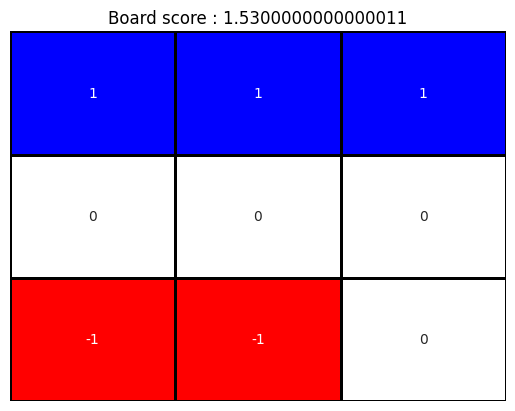

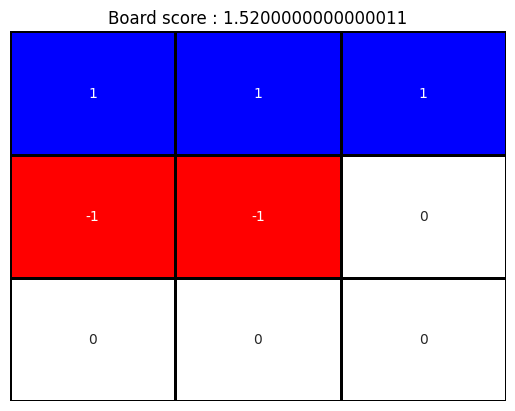

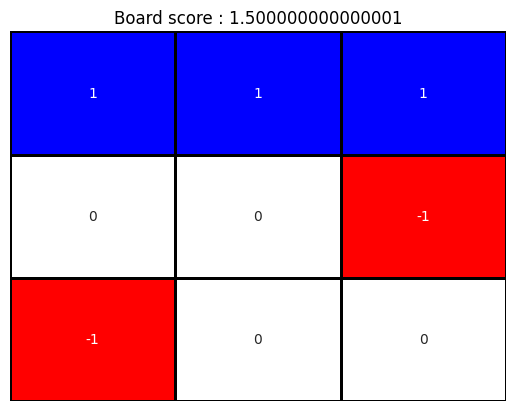

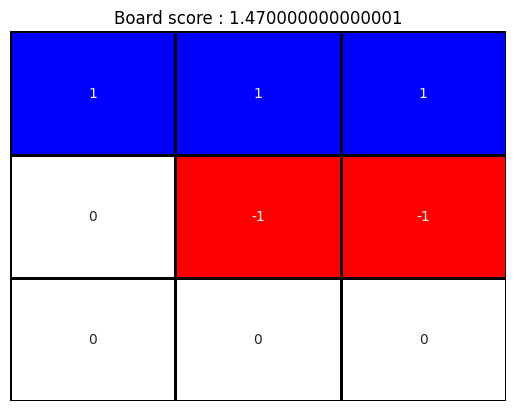

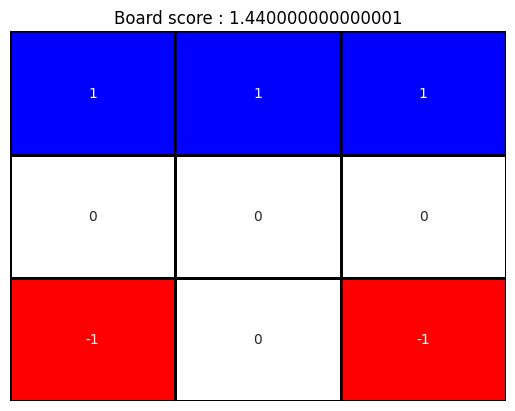

AI Agent 1 : Worst 5 states


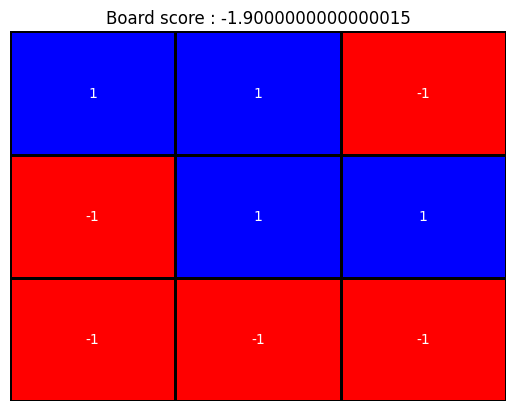

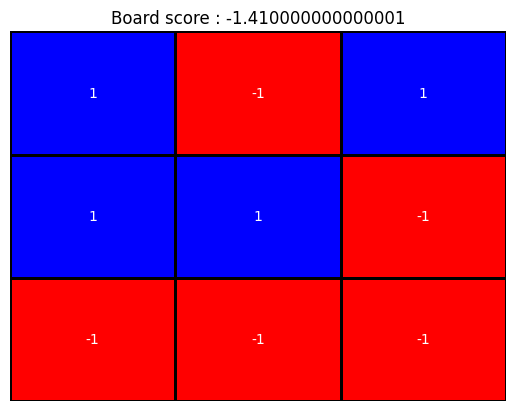

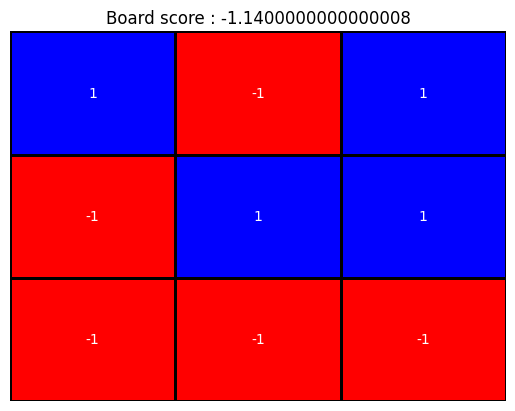

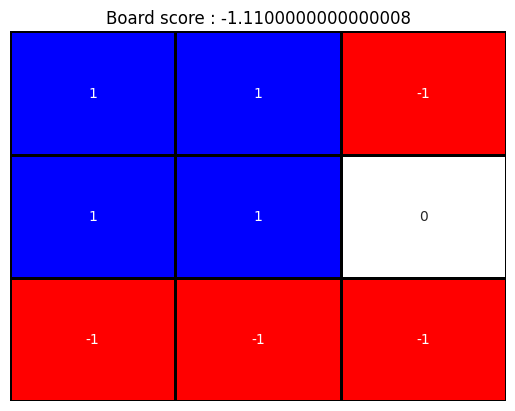

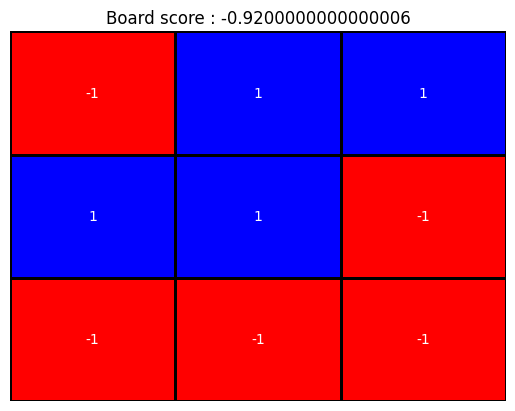

<Figure size 640x480 with 0 Axes>

In [14]:
ai1.visualizeStates(display, n_states=10)

AI Agent 2 : Best 5 states


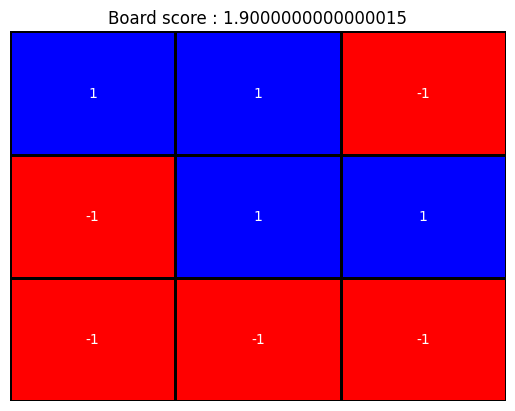

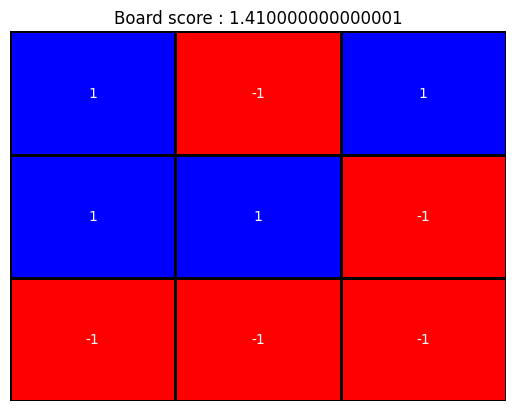

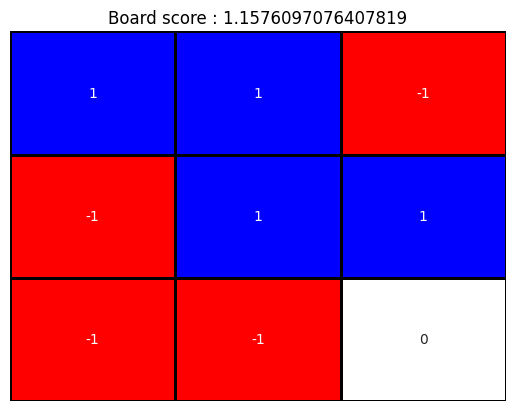

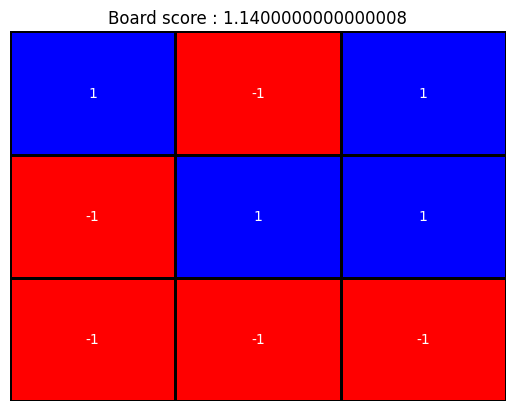

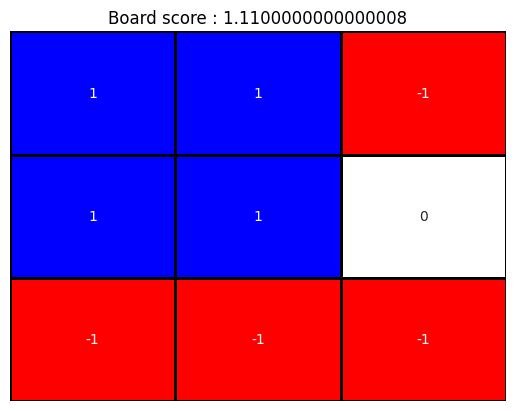

AI Agent 2 : Worst 5 states


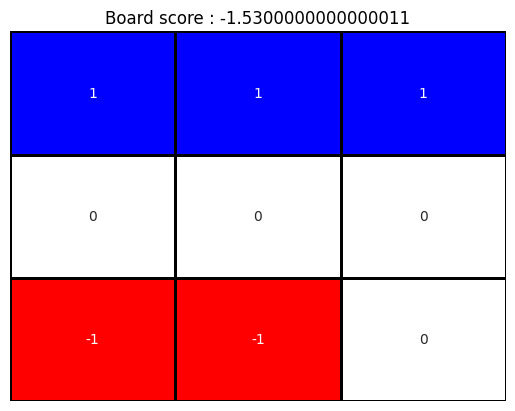

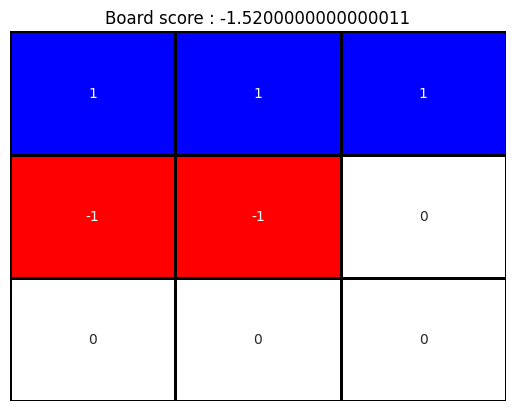

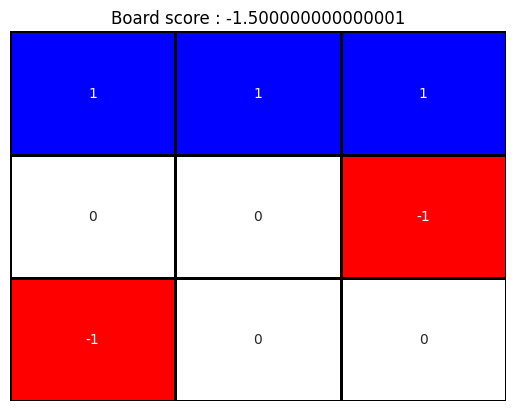

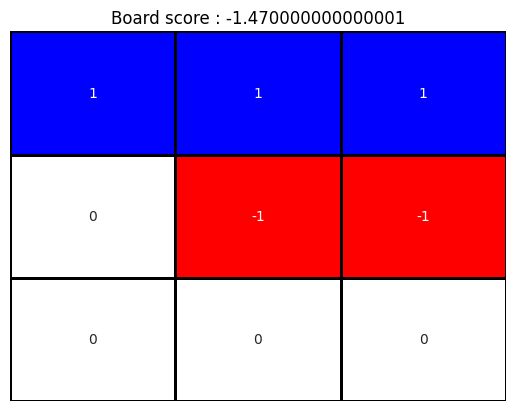

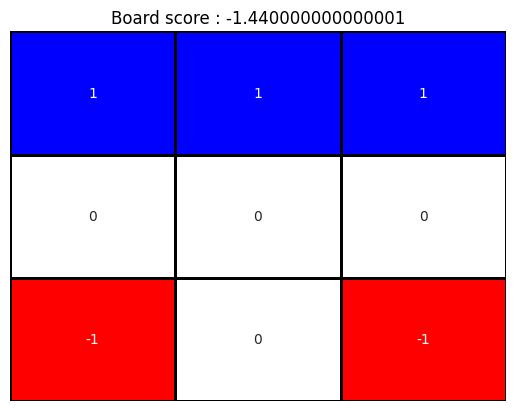

<Figure size 640x480 with 0 Axes>

In [15]:
ai2.visualizeStates(display, n_states=10)

In [16]:
print(f"Agent 1 has seen {len(ai1.state_values.keys())}/{3**9} possible states")
print(f"Agent 2 has seen {len(ai2.state_values.keys())}/{3**9} possible states")

Agent 1 has seen 5954/19683 possible states
Agent 2 has seen 5954/19683 possible states


In [17]:
print(f"Agent 1 has won {ai1.victories}/{int(1e4)} games")
print(f"Agent 2 has won {ai2.victories}/{int(1e4)} games")

Agent 1 has won 5561/10000 games
Agent 2 has won 3748/10000 games


Run game between human and AI

In [18]:
def playGame(game, num=1, learning=False, gif=False):
    human = game.vmap[-1]
    ai = game.vmap[1]
    automated = isinstance(human, AIActor)
    if automated:
        first_player = num % 2
    else:
        first_player = input(f"Who goes first? {game.vmap[1]}[0] or {game.vmap[-1]}[1]? ")
        while not first_player.isdigit():
            first_player = input(f"Who goes first? {game.vmap[1]}[0] or {game.vmap[-1]}[1]? ")
    first_player = int(first_player)
    game.reset()
    game.turn = 1 if first_player == 0 else -1
    
    if gif:
        player = []
        states = []
    while not game.ended:
        # Display current board
        # Run round
        current_round = game.round
        while current_round == game.round and not game.ended:
            if game.turn == 1:
                # AI move
                if gif:
                    states.append(game.copy().board)
                    player.append(str(ai))
                ai_move = ai.chooseAction(game.board)
                game.play(ai, ai_move)
            elif game.turn == -1:
                if gif:
                    states.append(game.copy().board)
                    player.append(str(human))
                clear_output()
                display(game.board)
                plt.show()
                # Human move
                if automated:
                    position = human.chooseAction(game.board)
                else:
                    position = [int(val) for val in input("Where do you want to play (x,y)? ").replace(' ', '').split(',')]
                    while not game.verifyPlay(position):
                        try:
                            position = [int(val) for val in input("WARNING : Invalid position. Where do you want to play (x,y)? ").replace(' ', '').split(',')]
                        except:
                            continue
                game.play(human, position)
            if learning:
                ai.addState(game.board)
                if automated:
                    human.addState(game.board)
    
    winner = game.winner()
    if gif:
        for filename in os.listdir('gifs'):
            if filename == f"Game_{num}.gif":
                os.remove(f"gifs/{filename}")
        # Source : https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30
        states.append(game.copy().board)
        filenames = []
        for i in range(len(states)):
            # For some reason, this iterates beyond number of states...
            if i >= len(states):
                break
            if i >= len(player):
                break
            p = player[i]
            state = states[i+1]
            fig = display(state).get_figure()
            filenames.append(f"State_{i+1}.png")
            fig.suptitle(f"{p} moves")
            if i == len(player) - 1:
                fig.suptitle(f"{p} WINS")
                if winner == 0:
                    fig.suptitle("It's a TIE")
            fig.savefig(f"State_{i+1}.png")
        with imageio.get_writer(f"gifs/Game_{num}.gif", mode="I") as writer:
            for filename in filenames:
                image = imageio.imread(filename)
                # Add extra frames to slow down
                for _ in range(10):
                    writer.append_data(image)
        for filename in set(filenames):
            os.remove(filename)
    if learning:
        game.reward()
        ai.reset()
    clear_output(wait=True)
    display(game.board)
    plt.show()
    if winner == 0:
        print("It's a TIE!")
        return winner
    if winner == 1:
        print(f"{ai} WINS!")
        return winner
    print(f"{human} WINS!")
    return winner

In [19]:
N_GAMES = 10

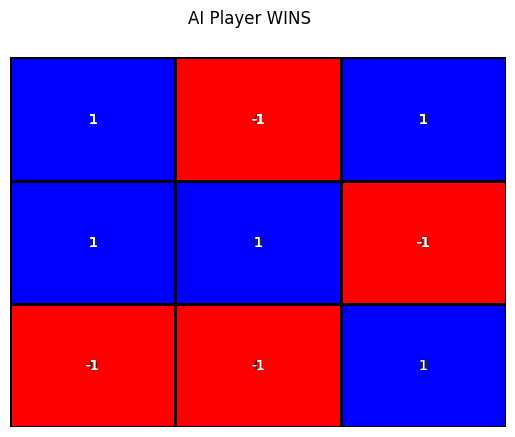

AI Player WINS!


In [21]:
# human = Actor(name="Human Player", value=-1, color="red")
rand_agent = AIActor(name="Random Player", value=-1, color="red", epsilon=1.)
ai = ai1
ai.name = "AI Player"
ai.reset()
ai.espilon = 0.1
ai.lr *= 10
# ai.epsilon = -1 # Force AI to always take best option
game = TicTacToe([ai, rand_agent])
save_nums = [1,10]
for n in range(N_GAMES):
    playGame(game, num=n+1, learning=True, gif=(n+1 in save_nums))

## First Game
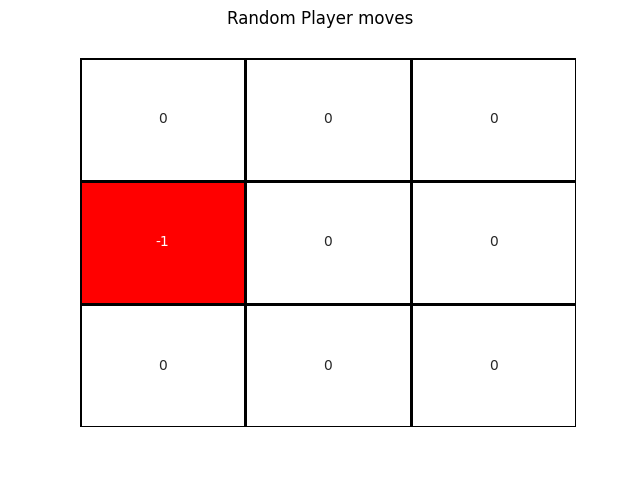
## Last Game
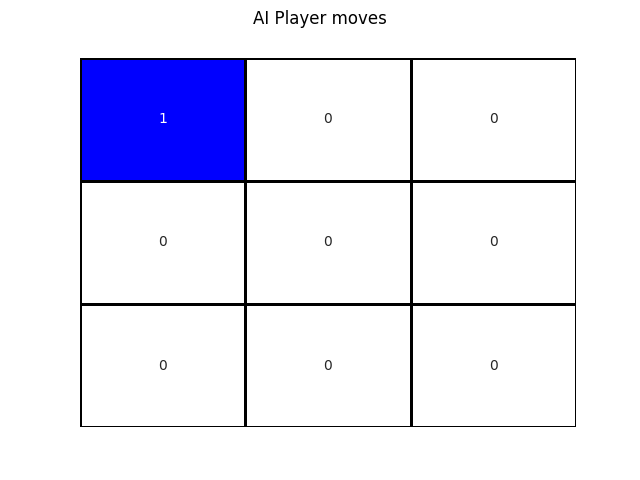